In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.base import clone

In [2]:
# 学習用モデルのインポート
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.linear_model import PassiveAggressiveRegressor, ARDRegression, RidgeCV
from sklearn.linear_model import TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.cross_decomposition import PLSRegression

### データの用意

In [3]:
df = pd.read_csv("train.csv")
df = df[["GrLivArea", "YearBuilt", "SalePrice"]]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   GrLivArea  1460 non-null   int64
 1   YearBuilt  1460 non-null   int64
 2   SalePrice  1460 non-null   int64
dtypes: int64(3)
memory usage: 34.3 KB


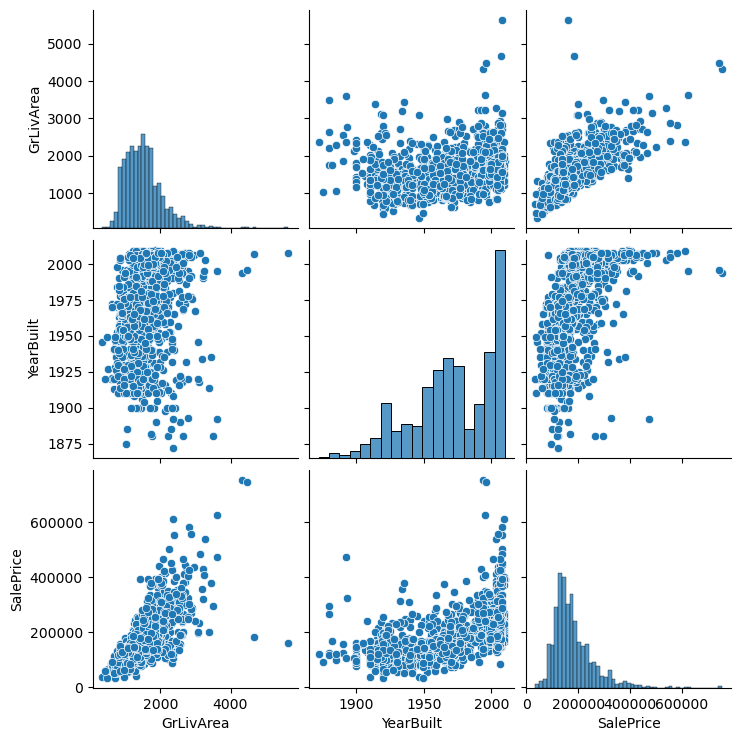

In [4]:
sns.pairplot(df)
plt.show()

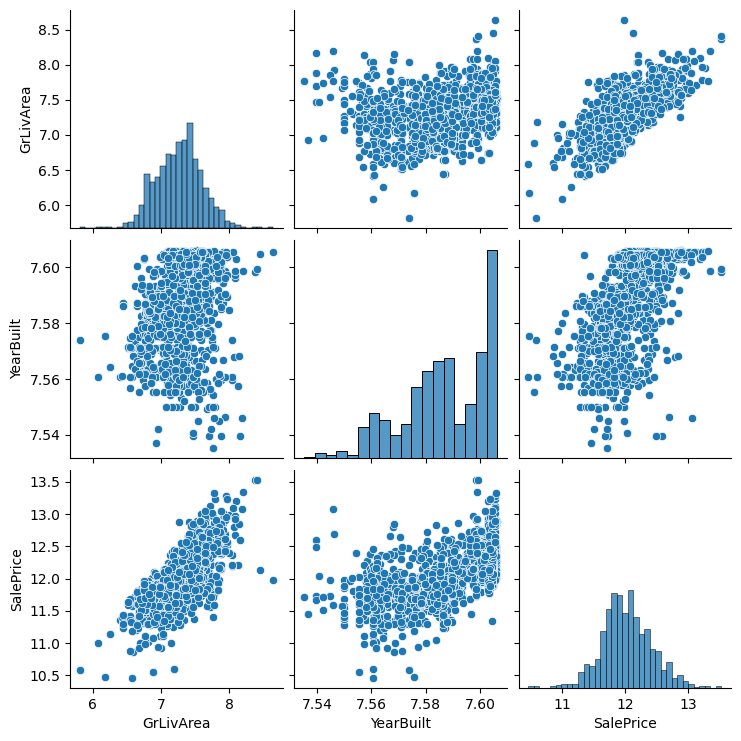

In [5]:
# 対数変換する
df_log = df.apply(np.log1p)
sns.pairplot(df_log)
plt.show()

In [6]:
# 訓練、テストに分割
X = df_log[["GrLivArea", "YearBuilt"]].values.astype(float)
y = df_log["SalePrice"].values.astype(float)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=100)
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_valid:', X_valid.shape)
print('y_valid:', y_valid.shape)

X_train: (1168, 2)
y_train: (1168,)
X_valid: (292, 2)
y_valid: (292,)


In [7]:
# 単一モデルでの精度を調べる関数
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

def singles(*models, n=5):
    for model in models:
        kf = KFold(n_splits=n, random_state=100, shuffle=True)
        result = -cross_val_score(model, X, y, cv=kf, scoring="neg_mean_squared_error")
        result_mean = np.mean(result)
        print(f"CV_MSE_MEAN:{result_mean}", "MODEL: ", str(model))

### 【問題1】ブレンディング

In [8]:
class BlendingRegressor:

    def __init__(self, *models):
        self.models = [model for model in models]

    def predict(self, X):
        preds = []
        for model in self.models:
            preds.append(model.predict(X))
        return np.mean(preds, axis=0)

#### ブレンディング1

In [24]:
# 単一モデルの精度
singles(LinearRegression(),
        SVR(),
        RandomForestRegressor())

CV_MSE_MEAN:0.04582741238844836 MODEL:  LinearRegression()
CV_MSE_MEAN:0.046766591263481525 MODEL:  SVR()
CV_MSE_MEAN:0.04649391093886758 MODEL:  RandomForestRegressor()


In [23]:
# ブレンディング
r1 = LinearRegression()
r2 = SVR()
r3 = RandomForestRegressor()
r1.fit(X_train, y_train)
r2.fit(X_train, y_train)
r3.fit(X_train, y_train)
b = BlendingRegressor(r1, r2, r3)
y_pred = b.predict(X_valid)
mse = mean_squared_error(y_valid, y_pred)
mse

0.044334648411970656

ごくわずかな精度向上

#### ブレンディング2

In [11]:
# 単一モデルの精度
singles(DecisionTreeRegressor(),
        MLPRegressor(),
        KNeighborsRegressor())

CV_MSE_MEAN:0.07597274454002888 MODEL:  DecisionTreeRegressor()
CV_MSE_MEAN:0.07514856337677144 MODEL:  MLPRegressor()
CV_MSE_MEAN:0.052475316537617646 MODEL:  KNeighborsRegressor()


In [12]:
# ブレンディング
r1 = DecisionTreeRegressor()
r2 = MLPRegressor()
r3 = KNeighborsRegressor()
r1.fit(X_train, y_train)
r2.fit(X_train, y_train)
r3.fit(X_train, y_train)
b = BlendingRegressor(r1, r2, r3)
y_pred = b.predict(X_valid)
mse = mean_squared_error(y_valid, y_pred)
mse

0.05002037079990577

そこそこの精度向上

#### ブレンディング3

In [13]:
# 単一モデルの精度
singles(Ridge(),
        MLPRegressor(),
        KNeighborsRegressor())

CV_MSE_MEAN:0.06383410640898672 MODEL:  Ridge()
CV_MSE_MEAN:0.07203298872632143 MODEL:  MLPRegressor()
CV_MSE_MEAN:0.052475316537617646 MODEL:  KNeighborsRegressor()


In [14]:
# ブレンディング
r1 = Ridge()
r2 = MLPRegressor()
r3 = KNeighborsRegressor()
r4 = SVR()
r1.fit(X_train, y_train)
r2.fit(X_train, y_train)
r3.fit(X_train, y_train)
r4.fit(X_train, y_train)
b = BlendingRegressor(r1, r2, r3, r4)
y_pred = b.predict(X_valid)
mse = mean_squared_error(y_valid, y_pred)
mse

0.051698827435904676

わずかな精度向上

### 【問題2】バギング

In [36]:
class BaggingRegressor:
    
    def __init__(self, model_init, n=10, bag_size=0.2):
        self.n = n
        self.bag_size = bag_size
        self.models = []
        for i in range(n):
            model = model_init()
            self.models.append(model)
    
    def fit(self, X, y):
        for i in range(self.n):
            X_bagging, X_, y_bagging, y_ = train_test_split(X, y, train_size=self.bag_size, shuffle=True, random_state=i)
            self.models[i].fit(X_bagging, y_bagging)
    
    def predict(self, X):
        preds = []
        for model in self.models:
            preds.append(model.predict(X))
        return np.mean(preds, axis=0)

In [41]:
# 単一モデルの精度
singles(DecisionTreeRegressor())

CV_MSE_MEAN:0.07557354386912725 MODEL:  DecisionTreeRegressor()


In [40]:
# バギング
ba = BaggingRegressor(DecisionTreeRegressor, n=100)
ba.fit(X_train, y_train)
y_pred = ba.predict(X_valid)
mse = mean_squared_error(y_valid, y_pred)
mse

0.04399261175033836

大幅に精度が向上した

### 【問題3】スタッキング

In [97]:
class StackingRegressor:
    """
    Parameters
    ----------
    models : list
      学習モデルを渡す
    splits : int
      ブレンドデータ作成時のデータ分割数（CV分割数）
    """
    def __init__(self, models, splits=3):
        self.max_depth = len(models)
        self.n_splits = splits
        self.models = models
        self.trained_models = []

    def blending(self, X, y, model):
        """
        ブレンドデータ作成機能
        Parameters
        ----------
        X : 次の形の ndarray、形状 (n_samples、n_features)
            訓練データの特徴
        y : 次の形の ndarray, shape (n_samples,)
            学習データのラベル値
        model : class
            トレーニングモデルのインスタンス
        """
        trained_models = []
        y_blend = np.zeros(len(X))
        kf = KFold(n_splits=self.n_splits, shuffle=False)
        for train_index, valid_index in kf.split(X):
            X_train, X_valid = X[train_index], X[valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
            y_train = y_train.ravel()
            y_valid = y_valid.ravel()
            m = clone(model)
            m.fit(X_train, y_train)
            # ブレンドデータ作成
            y_blend[valid_index] = m.predict(X_valid)
            # モデルを保存
            trained_models.append(m)
        self.trained_models.append(trained_models)
        return y_blend

    def fit(self, X, y):
        """
        この深さでブレンドデータを作成する
        Parameters
        ----------
        X : 次の形の ndarray、形状 (n_samples、n_features)
            訓練データの特徴
        y : 次の形の ndarray, shape (n_samples,)
            学習データのラベル値
        """
        # 最終学習モデル
        if self.max_depth == 1:
            self.models[0].fit(X, y)
            self.trained_models.append(self.models[0])
            return
        
        # この深さのトレーニングモデルを用意する
        models = self.models[0]
        y_blending = np.zeros([len(X), len(models)])
        
        # この深さのトレーニングモデルでブレンドデータを作る
        for i, model in enumerate(models):
            y_blend = self.blending(X, y, model)
            y_blending[:, i] = y_blend
        
        # 再帰する
        self.next = StackingRegressor(self.models[1:], splits=self.n_splits)
        self.next.fit(y_blending, y)

    def predict(self, X):
        if self.max_depth == 1:
            return self.trained_models[0].predict(X)
        y_pred = np.zeros((len(X), len(self.trained_models)))
        for i, models in enumerate(self.trained_models):
            for k, model in enumerate(models):
                y_pred[:, i] += model.predict(X)
            y_pred[:, i] = y_pred[:, i] / len(self.trained_models[i])
        return self.next.predict(y_pred)

In [134]:
model_list = [
    [MLPRegressor(), KNeighborsRegressor(), RandomForestRegressor()],
    [SVR(), HuberRegressor(), RandomForestRegressor()],
    [RandomForestRegressor(), ARDRegression()],
    LinearRegression()
]

In [136]:
# 単一モデルの精度
singles(*sum([(models if isinstance(models, list) else [models]) for models in model_list], []))

CV_MSE_MEAN:0.07331822074601049 MODEL:  MLPRegressor()
CV_MSE_MEAN:0.052475316537617646 MODEL:  KNeighborsRegressor()
CV_MSE_MEAN:0.04705830615357481 MODEL:  RandomForestRegressor()
CV_MSE_MEAN:0.046766591263481525 MODEL:  SVR()
CV_MSE_MEAN:0.04611779096196268 MODEL:  HuberRegressor()
CV_MSE_MEAN:0.04731878358562041 MODEL:  RandomForestRegressor()
CV_MSE_MEAN:0.04709033477779442 MODEL:  RandomForestRegressor()
CV_MSE_MEAN:0.04582767254539276 MODEL:  ARDRegression()
CV_MSE_MEAN:0.04582741238844836 MODEL:  LinearRegression()


In [135]:
# スタッキング
s = StackingRegressor(model_list, splits=5)
s.fit(X_train, y_train)
y_pred = s.predict(X_valid)
mse = mean_squared_error(y_valid, y_pred)
mse

0.044949654287173575

わずかに精度が向上した